
# SWOT L3 KaRIn and Nadir Ocean Data Products
This tutorial will introduce you to some sample SWOT L3 data products and show you how to download these data from AVISO and perform basic plots using Python related libraries.


<div class="alert alert-danger"><h4>Warning</h4><p>This tutorial is dedicated to **external use** of Swot data only, it cannot be ran inside CNES infrastructure because of the technical proxy. To know how to access Swot data from inside CNES infrastructure, please consult those notebooks: 

     * `sphx_glr_tutorials_auto_tutorials_discover_ex_data_query_zcoll.py`
     * `sphx_glr_tutorials_auto_tutorials_discover_ex_data_query_netcdf.py`
     * `sphx_glr_data_auto_data_access_ex_aviso_data_access.py`</p></div>



## Tutorial Objectives
* Present SWOT sample L3 data products (Basic and Expert versions)
* Show you how to find and visualize SWOT Sea Level Anomaly (SLA) data sets from AVISO FTP server
* Download locally SWOT KaRIn (2D swath) and nadir (along-track) altimetry combined data



## Import + code



In [1]:
# Install Cartopy with mamba to avoid discrepancies
# ! mamba install -q -c conda-forge cartopy

In [2]:
import requests
import numpy as np
import xarray as xr

import os
import ftplib
from getpass import getpass
import cartopy.crs as ccrs
import cartopy.feature as cft
import cartopy.mpl.geoaxes as cmplgeo
import cartopy.mpl.gridliner as cmplgrid
import matplotlib.pyplot as plt
# %matplotlib inline

In [3]:
def ftp_data_access(ftp_path, filename, username=None, password=None, local_filepath=None):
    # Set up FTP server details
    ftpAVISO = 'ftp-access.aviso.altimetry.fr'
    
    try:
        # Prompt for username and password
        if not username:
            username = input("Enter username for AVISO: ")
        if not password:
            password = getpass(prompt=f"Enter password for {username}: ")

        # Logging into FTP server using provided credentials
        with ftplib.FTP(ftpAVISO) as ftp:
            ftp.login(username, password)
            ftp.cwd(ftp_path)
            print(f"Connection Established {ftp.getwelcome()}")

            # Check if the file exists in the directory
            if filename in ftp.nlst():
                if not local_filepath: local_filepath = input("Enter the local directory to save the file: ")
                return download_file_from_ftp(ftp, filename, local_filepath)
            else:
                print(f"File {filename} does not exist in the directory.")
    except ftplib.error_perm as e:
        print(f"FTP error: {e}")
    except Exception as e:
        print(f"Error: {e}")

def download_file_from_ftp(ftp, filename, target_directory):
    try:
        local_filepath = os.path.join(target_directory, filename)
        with open(local_filepath, 'wb') as file:
            ftp.retrbinary('RETR %s' % filename, file.write)
            print(f"Downloaded {filename} to {local_filepath}")
            return local_filepath
    except Exception as e:
        print(f"Error downloading {filename}: {e}")

## Parameters
Define a local filepath to download files



In [4]:
local_filepath='/tmp'

### Authentication parameters
Enter your AVISO+ credentials



In [6]:
username = input("Enter username:")

Enter username: cyril.germineaud@cnes.fr


In [7]:
password = getpass(f"Enter password for {username}:")

Enter password for cyril.germineaud@cnes.fr: ········


## FTP download



In [8]:
# Define directories
ftp_path_basic = '/swot_products/l3_karin_nadir/l3_lr_ssh/v1_0/Basic/cycle_550/'
filename_basic = 'SWOT_L3_LR_SSH_Basic_550_012_20230612T193204_20230612T202308_v1.0.nc'

# FTP download
half_orbit_basic = ftp_data_access(ftp_path_basic, filename_basic, username, password, local_filepath)
half_orbit_basic

Connection Established 220 192.168.10.119 FTP server ready
Downloaded SWOT_L3_LR_SSH_Basic_550_012_20230612T193204_20230612T202308_v1.0.nc to /tmp/SWOT_L3_LR_SSH_Basic_550_012_20230612T193204_20230612T202308_v1.0.nc


'/tmp/SWOT_L3_LR_SSH_Basic_550_012_20230612T193204_20230612T202308_v1.0.nc'

In [9]:
# Define directories
ftp_path_expert = '/swot_products/l3_karin_nadir/l3_lr_ssh/v1_0/Expert/cycle_488/'
filename_expert = 'SWOT_L3_LR_SSH_Expert_488_007_20230412T005730_20230412T014836_v1.0.nc'

# FTP download
half_orbit_expert = ftp_data_access(ftp_path_expert, filename_expert, username, password, local_filepath)
half_orbit_expert

Connection Established 220 192.168.10.119 FTP server ready
Downloaded SWOT_L3_LR_SSH_Expert_488_007_20230412T005730_20230412T014836_v1.0.nc to /tmp/SWOT_L3_LR_SSH_Expert_488_007_20230412T005730_20230412T014836_v1.0.nc


'/tmp/SWOT_L3_LR_SSH_Expert_488_007_20230412T005730_20230412T014836_v1.0.nc'

### Select regional boundaries

In [10]:
localbox = [-90, -30, 20, 60] # Gulf Stream

## Discover SWOT L3 Ocean Basic product



### Basic product content
This product contains two versions of SLA (ssha in the datasets). The ssha_noiseless field is obtained by denoising the ssha field. The mean dynamic topography is also included in order to derive the absolute dynamic topography. Finally, the nadir sea level anomaly has been combined in the KaRIn swath, with the i_num_line and i_num_pixel fields indexing its location in the grid.



In [11]:
ds_basic =  xr.open_dataset(half_orbit_basic)
[v for v in ds_basic.variables]

['time',
 'latitude',
 'longitude',
 'mdt',
 'ssha',
 'ssha_noiseless',
 'i_num_line',
 'i_num_pixel']

### Expert product content
This product contains all the Basic fields, and additionnal fields that allows a deeper investigation by Expert users. This includes the corrections used for the SLA and the currents (absolute and relative) computed for the denoised SLA.



In [12]:
ds_expert = xr.open_dataset(half_orbit_expert)
[v for v in ds_expert.variables if v not in ds_basic]
ds_expert = ds_expert.assign_coords(longitude=(((ds_expert.longitude + 180) % 360) - 180))

# Select data over the region
lolasubset = (
(ds_expert.longitude > localbox[0]) &
(ds_expert.longitude < localbox[1]) &
(ds_expert.latitude > localbox[2]) &
(ds_expert.latitude < localbox[3]))

ds_expert_sub = ds_expert.where(lolasubset, drop=True)
ds_expert_sub

<xarray.Dataset> Size: 2GB
Dimensions:               (num_lines: 2317, num_pixels: 69, num_nadir: 1631)
Coordinates:
    latitude              (num_lines, num_pixels) float64 1MB 20.02 ... 59.99
    longitude             (num_lines, num_pixels) float64 1MB -52.24 ... -35.55
Dimensions without coordinates: num_lines, num_pixels, num_nadir
Data variables: (12/18)
    time                  (num_lines, num_pixels) datetime64[ns] 1MB 2023-04-...
    mdt                   (num_lines, num_pixels) float64 1MB 0.5689 ... -0.5366
    ssha                  (num_lines, num_pixels) float64 1MB nan nan ... nan
    ssha_noiseless        (num_lines, num_pixels) float64 1MB nan nan ... nan
    ssha_unedited         (num_lines, num_pixels) float64 1MB nan nan ... nan
    quality_flag          (num_lines, num_pixels) float32 639kB 102.0 ... 102.0
    ...                    ...
    ugosa                 (num_lines, num_pixels) float64 1MB nan nan ... nan
    vgosa                 (num_lines, num_pixels) float64 1MB nan nan ... nan
    sigma0                (num_lines, num_pixels) float64 1MB nan nan ... nan
    cross_track_distance  (num_pixels, num_lines) float64 1MB -68.0 ... 68.0
    i_num_line            (num_nadir, num_lines, num_pixels) float32 1GB 722....
    i_num_pixel           (num_nadir, num_lines, num_pixels) float32 1GB 34.0...
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    ...                              ...
    geospatial_lat_min:              -78.272196
    geospatial_lat_max:              78.272247
    geospatial_lon_min:              0.000835
    geospatial_lon_max:              359.99901
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0 (NASA/CNES). D...
    doi:                             https://doi.org/10.24400/527896/A01-2023...

### SWOT nadir data
The nadir data can be extracted from the dataset using the i_num_line and i_num_pixel indexes.
The nadir positions and time are an estimation that combines the swath positions and time with the indexes.



In [13]:
# Build nadir variable
ds_expert["time_nadir"] = ds_expert.time[ds_expert.i_num_line]
ds_expert["longitude_nadir"] = ds_expert.longitude[ds_expert.i_num_line, ds_expert.i_num_pixel]
ds_expert["latitude_nadir"] = ds_expert.latitude[ds_expert.i_num_line, ds_expert.i_num_pixel]
ds_expert["sla_nadir"] = ds_expert.ssha[ds_expert.i_num_line, ds_expert.i_num_pixel]

# Select nadir data over the region (using num_nadir dimension only)
lolasubset_nadir = (
(ds_expert.longitude_nadir > localbox[0]) &
(ds_expert.longitude_nadir < localbox[1]) &
(ds_expert.latitude_nadir > localbox[2]) &
(ds_expert.latitude_nadir < localbox[3]))

ds_nadir = ds_expert.drop_dims(["num_lines", "num_pixels"]).where(lolasubset_nadir, drop=True)
ds_nadir

<xarray.Dataset> Size: 27kB
Dimensions:          (num_nadir: 668)
Dimensions without coordinates: num_nadir
Data variables:
    i_num_line       (num_nadir) float32 3kB 6.05e+03 6.053e+03 ... 8.346e+03
    i_num_pixel      (num_nadir) float32 3kB 34.0 34.0 34.0 ... 34.0 34.0 34.0
    time_nadir       (num_nadir) datetime64[ns] 5kB 2023-04-12T01:28:52.20371...
    longitude_nadir  (num_nadir) float64 5kB -51.58 -51.57 ... -36.94 -36.88
    latitude_nadir   (num_nadir) float64 5kB 20.01 20.06 20.13 ... 59.92 59.99
    sla_nadir        (num_nadir) float64 5kB 0.091 0.087 0.08 ... 0.016 0.012
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    ...                              ...
    geospatial_lat_min:              -78.272196
    geospatial_lat_max:              78.272247
    geospatial_lon_min:              0.000835
    geospatial_lon_max:              359.99901
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0 (NASA/CNES). D...
    doi:                             https://doi.org/10.24400/527896/A01-2023...

### Visualize the data: basic SLA plots
Let's visualize SWOT KaRIn abd Nadir data using cartopy.
Adapt this code to visualize other variables or regions, or try importing another file.



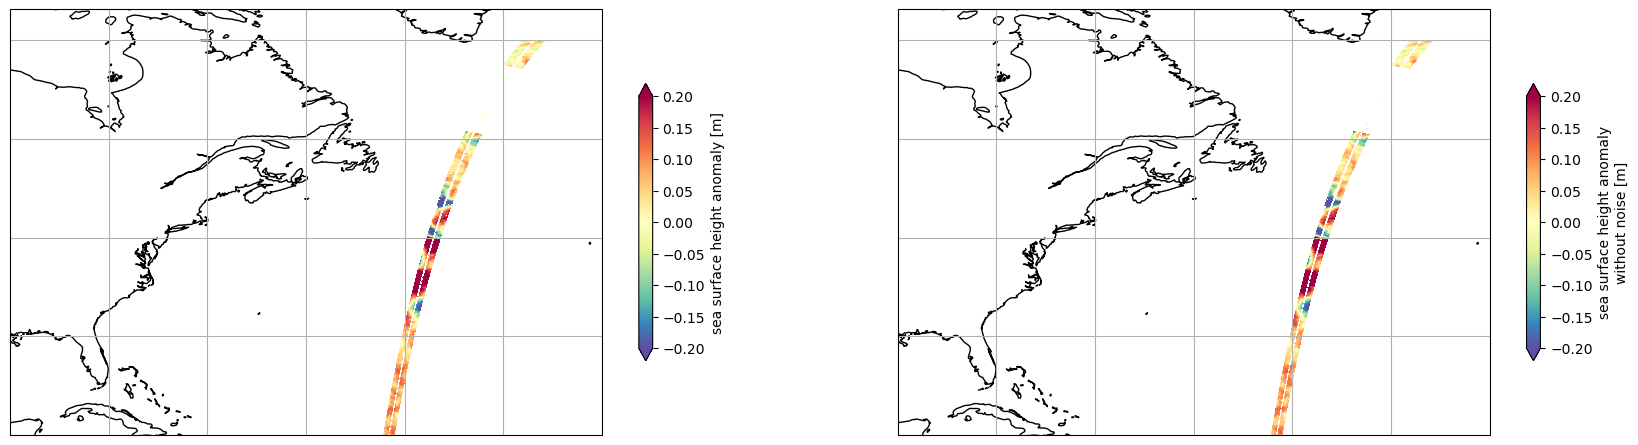

In [14]:
# set figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax1.set_extent(localbox)
ax2.set_extent(localbox)
plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="Spectral_r",
    vmin=-0.2,
    vmax=0.2,
    cbar_kwargs={"shrink": 0.3},)

# SWOT KaRIn SLA plots
ds_expert_sub.ssha.plot.pcolormesh(ax=ax1, **plot_kwargs)
ds_expert_sub.ssha_noiseless.plot.pcolormesh(ax=ax2, **plot_kwargs)
#
ax1.coastlines()
ax1.gridlines()
ax2.coastlines()
ax2.gridlines()

Text(0.5, 0, 'latitude [degrees_north]')

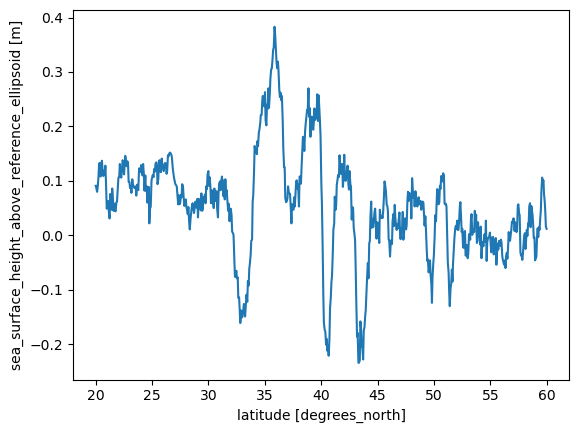

In [15]:
plt.plot(ds_nadir.latitude_nadir.values, ds_nadir.sla_nadir.values)
plt.ylabel(f'{ds_nadir.sla_nadir.attrs["standard_name"]} [{ds_nadir.sla_nadir.attrs["units"]}]')
plt.xlabel(f'{ds_nadir.latitude_nadir.attrs["standard_name"]} [{ds_nadir.latitude_nadir.attrs["units"]}]')

### Remove nadir data from L3 data set
It is possible to remove the nadir data combined with L3 KaRIn data.



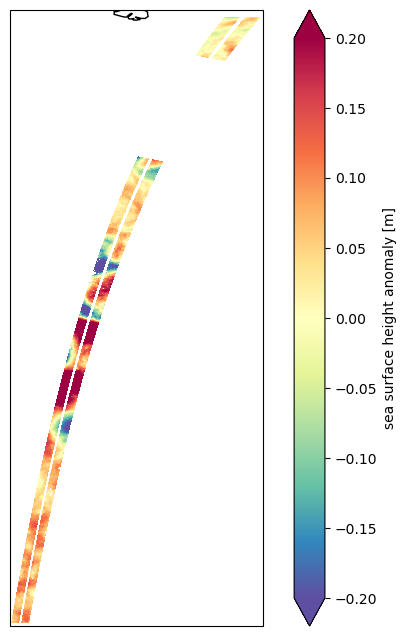

In [16]:
# Masking must be done prior regional subsetting
ssha = ds_expert.ssha
ssha[ds_expert.i_num_line, ds_expert.i_num_pixel] = np.nan

# Regional subsetting
ssha_area = ssha.where(lolasubset, drop=True)

# plot SLA KaRIn data only
del plot_kwargs["cbar_kwargs"]
mesh = ssha_area.plot.pcolormesh(
figsize=(8, 8),
subplot_kws=dict(projection=ccrs.PlateCarree()),
**plot_kwargs)
mesh.axes.coastlines()